In [2]:
#libraries required for launching Spark SQL and analysis purpose
from pyspark.sql import SQLContext 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
#Importing sql in a sparksession 
from pyspark.sql import SparkSession 
spark = SparkSession.builder.getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/11/13 10:06:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
#importing the  csv dataset from my computer
base = "/Users/bobchryz/Desktop/BDAAIML Project/"
df = spark.read.csv(base+'Cardekho.csv', header=True, inferSchema=True)
print(df.show(10))

+--------------------+------------+-------------+---------+-----------+-----------+---------+-----------+---------+-----------------+-------+-------+------------+-----+
|        Vehicle Name|buying_price|selling_price|make_year|vehicle_age|seller_type|km_driven| owner_type|fuel_type|transmission_type|mileage| engine|max_powe_bhp|Seats|
+--------------------+------------+-------------+---------+-----------+-----------+---------+-----------+---------+-----------------+-------+-------+------------+-----+
|     Maruti Alto Std|        null|          1.2|     2012|          8| Individual| 1,20,000|First Owner|   Petrol|           Manual|   19.7| 796 CC|        46.3|    5|
|Hyundai Grand i10...|        7.11|          5.5|     2016|          4| Individual|   20,000|First Owner|   Petrol|           Manual|   18.9|1197 CC|          82|    5|
|    Hyundai i20 Asta|        null|         2.15|     2010|         10| Individual|   60,000|First Owner|   Petrol|           Manual|   17.0|1197 CC|      

In [5]:
#since we have plently of data, we are dropping columns as a part of dimentional reduction to optimise the dataset quality
columns_to_drop = ['engine',  'max_powe_bhp', 'Seats']
df = df.drop(*columns_to_drop)

In [6]:
#couting how many null values are still left
df.toPandas().isna().sum()

Vehicle Name             0
buying_price         10459
selling_price            0
make_year               45
vehicle_age              1
seller_type              0
km_driven                0
owner_type               0
fuel_type                0
transmission_type        0
mileage                 45
dtype: int64

In [7]:
#removing all the null values columns
df = df.dropna()

In [8]:
#importing additional libraries column based user defined functions 
from pyspark.sql.functions import udf,col
from pyspark.sql.types import StringType, IntegerType


In [9]:
#Standardizing the Dataset as the values were in different format
def format_num(x):
  if x.endswith("Cr"):
    x = x.replace("Cr", "")
    x = float(x)*10000000
  else:
    x = float(x)*100000
  return int(x)

format_num_function = udf(lambda x:format_num(x),IntegerType() )

In [10]:
df = df.withColumn("buying_price",format_num_function(col("buying_price")))

In [11]:
df = df.withColumn("selling_price",format_num_function(col("selling_price")))

In [12]:
df.show(5)

+--------------------+------------+-------------+---------+-----------+-----------+---------+-----------+---------+-----------------+-------+
|        Vehicle Name|buying_price|selling_price|make_year|vehicle_age|seller_type|km_driven| owner_type|fuel_type|transmission_type|mileage|
+--------------------+------------+-------------+---------+-----------+-----------+---------+-----------+---------+-----------------+-------+
|Hyundai Grand i10...|      711000|       550000|     2016|          4| Individual|   20,000|First Owner|   Petrol|           Manual|   18.9|
|Ford Ecosport 201...|     1014000|       570000|     2015|          5|     Dealer|   30,000|First Owner|   Diesel|           Manual|  22.77|
|Maruti Wagon R VX...|      516000|       350000|     2013|          7| Individual|   35,000|First Owner|   Petrol|           Manual|   18.9|
|Hyundai i10 Sport...|      654000|       315000|     2013|          7|     Dealer|   40,000|First Owner|   Petrol|           Manual|  20.36|
|  Mar

Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 663, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
EOFError


In [13]:
#Naming the modified table
df.createOrReplaceTempView("NITCA")
df.count()

9566

In [14]:
#putting a trashhold to limit age 100 of vehicle 
df = spark.sql("SELECT * FROM NITCA WHERE vehicle_age <100")

In [15]:
#checking schema to understand the value type 
df.printSchema()

root
 |-- Vehicle Name: string (nullable = true)
 |-- buying_price: integer (nullable = true)
 |-- selling_price: integer (nullable = true)
 |-- make_year: integer (nullable = true)
 |-- vehicle_age: integer (nullable = true)
 |-- seller_type: string (nullable = true)
 |-- km_driven: string (nullable = true)
 |-- owner_type: string (nullable = true)
 |-- fuel_type: string (nullable = true)
 |-- transmission_type: string (nullable = true)
 |-- mileage: double (nullable = true)



In [16]:
#using group functions for analysing purpose
df.groupBy('vehicle name').mean('buying_price', 'Vehicle_age').show(10)

+--------------------+------------------+------------------+
|        vehicle name| avg(buying_price)|  avg(Vehicle_age)|
+--------------------+------------------+------------------+
| Honda City 1.5 S MT|         1283000.0| 9.807017543859649|
|Toyota Innova Cry...|         2056714.0|2.7142857142857144|
|Volkswagen Vento ...|      1053124.9375|            4.8125|
|Mahindra Bolero 2...| 899166.5833333334| 5.416666666666667|
|Honda City i DTec...|1453636.3636363635| 4.181818181818182|
|    Datsun GO Plus A| 509333.3333333333| 4.333333333333333|
|Datsun GO Anniver...|          452500.0|               3.0|
|Maruti Ciaz 1.4 A...|        983062.125|               2.5|
|Hyundai Grand i10...|          714000.0|               3.5|
|Hyundai i20 1.4 Asta|          961111.0|1.8888888888888888|
+--------------------+------------------+------------------+
only showing top 10 rows



In [17]:
#using group functions for analysing purpose
df.groupBy('vehicle name').count().show(10)

+--------------------+-----+
|        vehicle name|count|
+--------------------+-----+
| Honda City 1.5 S MT|   57|
|Toyota Innova Cry...|    7|
|Volkswagen Vento ...|   16|
|Mahindra Bolero 2...|   12|
|Honda City i DTec...|   11|
|    Datsun GO Plus A|    3|
|Datsun GO Anniver...|    2|
|Maruti Ciaz 1.4 A...|   16|
|Hyundai Grand i10...|    4|
|Hyundai i20 1.4 Asta|    9|
+--------------------+-----+
only showing top 10 rows



In [18]:
# Saving the modified file as cardekho dataset_G2 
# df.to_csv('cardekho dataset_G2.csv')

In [19]:
#some important libraries for ploty graphs

import numpy as np
from sklearn import metrics
import plotly.express as px

In [20]:
#Re-importing the newly created dataset
cd = pd.read_csv('/Users/bobchryz/Desktop/BDAAIML Project/cardekho dataset_G2.csv')

In [21]:
cd.head()

,sl_no,vehicle_name,buying_price,selling_price,make_year,vehicle_age,seller_type,km_driven,owner_type,fuel_type,transmission_type,mileage
0,0,Hyundai Grand i10 Asta,711000,550000,2016,4,Individual,20000,First Owner,Petrol,Manual,18.90
1,1,Ford Ecosport 2015-2021 1.5 TDCi Titanium BSIV,1014000,570000,2015,5,Dealer,30000,First Owner,Diesel,Manual,22.77
2,2,Maruti Wagon R VXI BS IV,516000,350000,2013,7,Individual,35000,First Owner,Petrol,Manual,18.90
3,3,Hyundai i10 Sportz 1.2,654000,315000,2013,7,Dealer,40000,First Owner,Petrol,Manual,20.36
4,4,Maruti Wagon R VXI,526000,409999,2018,2,Dealer,17512,First Owner,Petrol,Manual,20.51


In [22]:
#creating a new column with name company from the car name

cd["company"] = cd["vehicle_name"].str.partition(" ")[0]

In [23]:
#To check whether the new column has been created or not
cd.head()

,sl_no,vehicle_name,buying_price,selling_price,make_year,vehicle_age,seller_type,km_driven,owner_type,fuel_type,transmission_type,mileage,company
0,0,Hyundai Grand i10 Asta,711000,550000,2016,4,Individual,20000,First Owner,Petrol,Manual,18.90,Hyundai
1,1,Ford Ecosport 2015-2021 1.5 TDCi Titanium BSIV,1014000,570000,2015,5,Dealer,30000,First Owner,Diesel,Manual,22.77,Ford
2,2,Maruti Wagon R VXI BS IV,516000,350000,2013,7,Individual,35000,First Owner,Petrol,Manual,18.90,Maruti
3,3,Hyundai i10 Sportz 1.2,654000,315000,2013,7,Dealer,40000,First Owner,Petrol,Manual,20.36,Hyundai
4,4,Maruti Wagon R VXI,526000,409999,2018,2,Dealer,17512,First Owner,Petrol,Manual,20.51,Maruti


In [24]:
#reverying is some null value has been created while creating a new column
cd.isna().sum()

sl_no                0
vehicle_name         0
buying_price         0
selling_price        0
make_year            0
vehicle_age          0
seller_type          0
km_driven            0
owner_type           0
fuel_type            0
transmission_type    0
mileage              0
company              0
dtype: int64

<AxesSubplot:xlabel='seller_type', ylabel='count'>

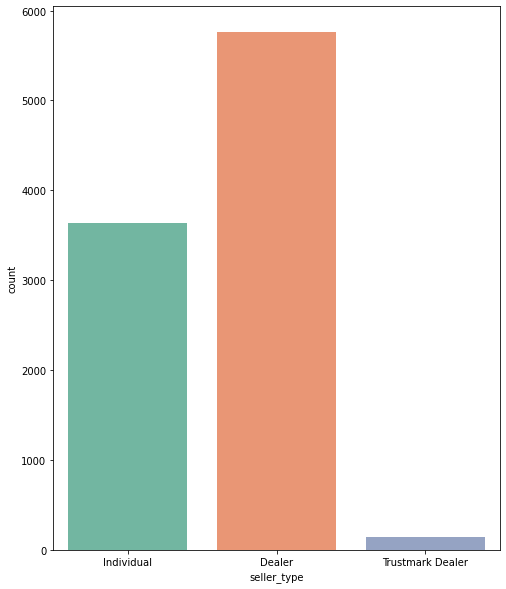

In [25]:
#bar chart to count of Seller Types
figure = plt.figure(figsize=(8,10))
sns.countplot(x='seller_type', data=cd, palette="Set2")

Count of Fuel Types

<AxesSubplot:xlabel='fuel_type', ylabel='count'>

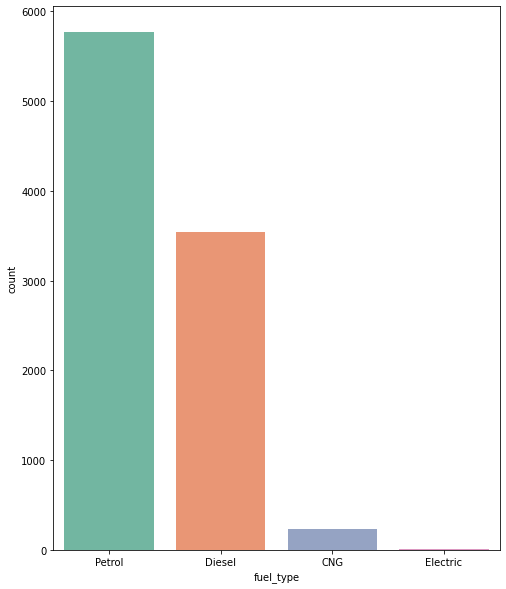

In [26]:
figure = plt.figure(figsize=(8,10))
sns.countplot(x='fuel_type', data=cd, palette="Set2")

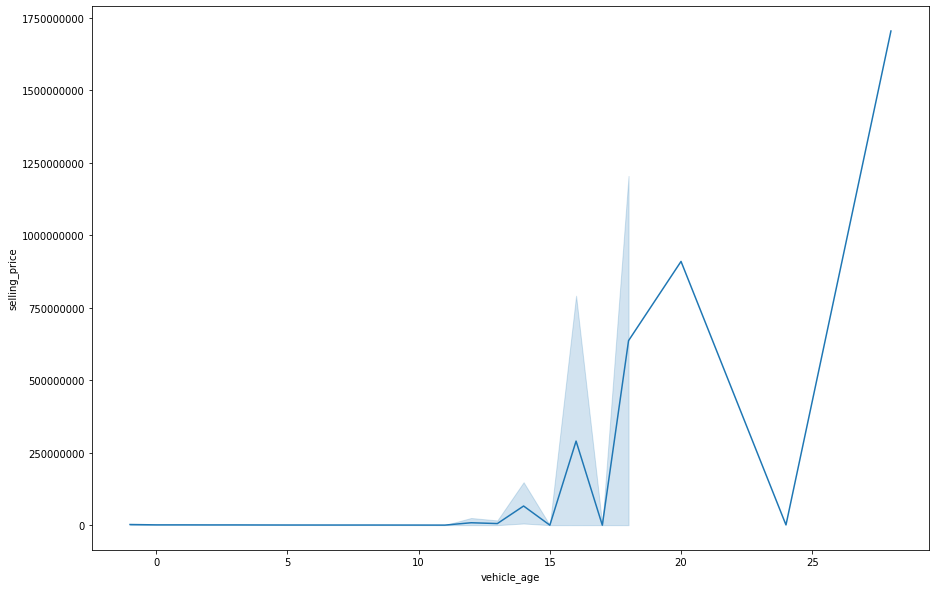

In [37]:
#SellingPrice vs VehicleAge

plt.figure(figsize=(15,10))
sns.lineplot(x='vehicle_age',y='selling_price',data=cd)
plt.ticklabel_format(style='plain')

In [ ]:
#Comparison of Selling Price, Cost Price and Kilometers Driven

plt.figure(figsize=(40,40))
fig = px.scatter_3d(cd, x='vehicle_age', y='km_driven', z='selling_price', color='company')
fig.show()

<Figure size 2880x2880 with 0 Axes>

<AxesSubplot:xlabel='company'>

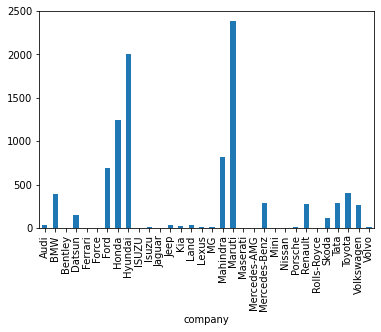

In [ ]:
new = cd.groupby('company').size()
new.plot.bar()

In [ ]:
#data=mapping(data,"buying_price")

Normalising the coloums separately

In [ ]:
#cd["mileage"]=((cd["mileage"]-cd["mileage"].min())/(cd["mileage"].max()-cd["mileage"].min()))*25

In [ ]:
#cd.sample(5)

In [ ]:
#cd.hist()